In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pynamicalsys import DiscreteDynamicalSystem as dds
from pynamicalsys import ContinuousDynamicalSystem as cds
from pynamicalsys import PlotStyler
from utils import propagate_error, format_mean_std
from models import henon_map_3D, henon_map_3D_jacobian, logistic_map_network, logistic_map_network_jacobian, cat_map, cat_map_jacobian, baker_map, baker_map_jacobian, fermi_pasta_ulam, fermi_pasta_ulam_energy, fermi_pasta_ulam_jacobian
from string import ascii_lowercase
from parameters import HENON, LOGISTIC_MAP_NETWORK, CATMAP, BAKERMAP, FPU

In [2]:
import os
os.makedirs("Figures", exist_ok=True)

# Fig. 1

In [ ]:
ds = dds(mapping=henon_map_3D, jacobian=henon_map_3D_jacobian, system_dimension=3, number_of_parameters=3)

In [ ]:
parameters = HENON["parameters"]
u = HENON["u0"]
sample_size = HENON["sample_size"]
transient_time = HENON["transient_time" ]
total_time = sample_size + transient_time

In [ ]:
trajectory = ds.trajectory(u, total_time, parameters=parameters, transient_time=transient_time)

<Figure size 640x480 with 0 Axes>

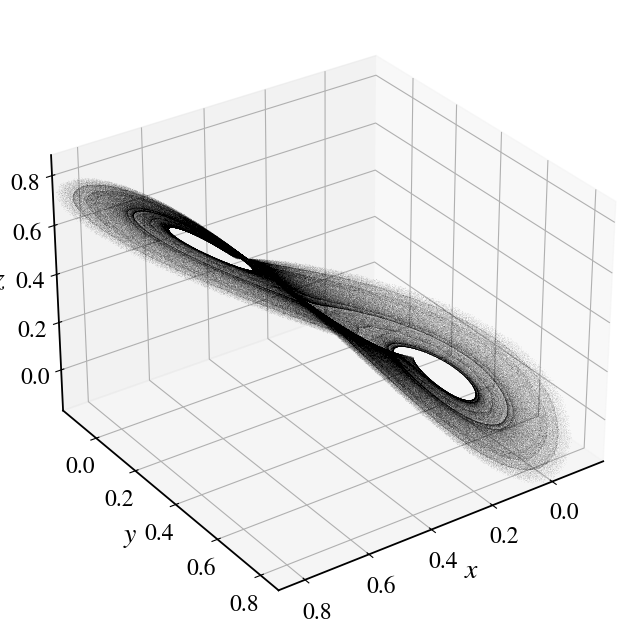

In [ ]:
ps = PlotStyler(fontsize=20, markersize=0.1, markeredgewidth=0)
ps.apply_style()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], "ko", zorder=1)

xmin, ymin, zmin = np.min(trajectory[:, 0]), np.min(trajectory[:, 1]), np.min(trajectory[:, 2])
xmax, ymax, zmax = np.max(trajectory[:, 0]), np.max(trajectory[:, 1]), np.max(trajectory[:, 2])

ax.view_init(elev=30, azim=55)  # elevation and azimuthal angle
ax.grid(True)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_zlim(zmin, zmax)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
# plt.tight_layout()
plt.savefig("Figures/fig1.png", dpi=400)

# Fig. 2

In [3]:
ds = dds(mapping=henon_map_3D, jacobian=henon_map_3D_jacobian, system_dimension=3, number_of_parameters=3)

In [4]:
parameters = np.array(HENON["parameters"])
u = HENON["u0"]
sample_size = HENON["sample_size"]
transient_time = HENON["transient_time" ]
total_time = sample_size + transient_time
times = np.arange(1, sample_size + 1)

In [5]:
lyapunov = ds.lyapunov(u, total_time, parameters=parameters, transient_time=transient_time, return_history=True)

In [6]:
k = 3
np.random.seed(10)
v = -1 + 2 * np.random.rand(3, k)
# Normalize the vectors
v, _ = np.linalg.qr(v)
singular_values = np.zeros((sample_size, k))

for i in range(sample_size):
    u = henon_map_3D(u, parameters)
    J = henon_map_3D_jacobian(u, parameters)

    for j in range(k):
        v[:, j] = J @ v[:, j]
        v[:, j] /= np.linalg.norm(v[:, j])

    singular_values[i] = np.linalg.svd(v, full_matrices=False, compute_uv=False)

<Figure size 640x480 with 0 Axes>

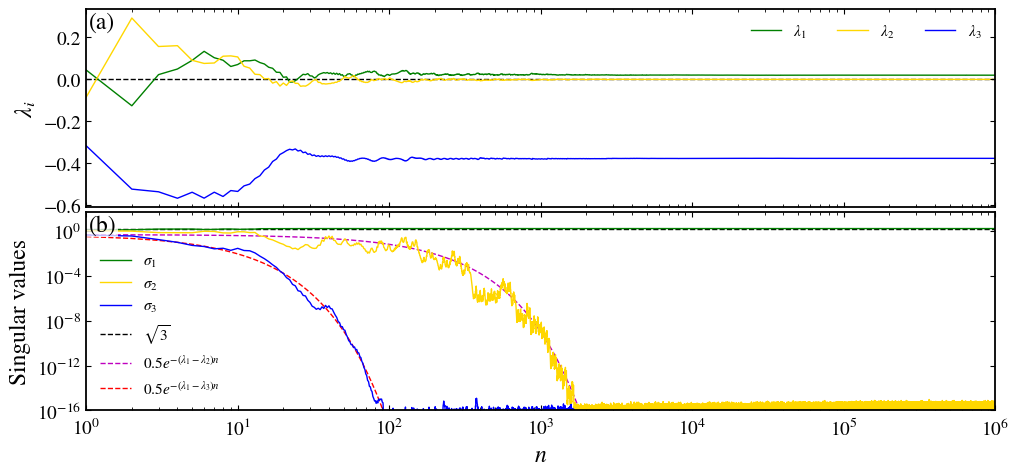

In [10]:
ps = PlotStyler(fontsize=17, legend_fontsize=11)
ps.apply_style()
colors = ["green", "gold", "blue"]

fig, ax = plt.subplots(2, 1, figsize=(10, 4.5), sharex=True)
ps.set_tick_padding(ax[1], pad_x=5)

for i in range(lyapunov.shape[1]):
    ax[0].plot(times, lyapunov[:, i], c=colors[i], label=rf"$\lambda_{i + 1}$", zorder=1)
    ax[1].plot(times, singular_values[:, i], c=colors[i], label=rf"$\sigma_{i + 1}$")

ax[1].axhline(np.sqrt(3), color="k", ls="--", label=r"$\sqrt{3}$", zorder=0)
ax[1].plot(times, 0.5 * np.exp(-(lyapunov[-1, 0] - lyapunov[-1, 1]) * times), "--", color="m", label=r"$0.5e^{-(\lambda_1 - \lambda_2)n}$", zorder=0)

ax[1].plot(times, 0.5 * np.exp(-((lyapunov[-1, 0] - lyapunov[-1, 2])) * times), "--", color="red", label=r"$0.5e^{-(\lambda_1 - \lambda_3) n}$", zorder=0)

ax[0].legend(loc="upper right", frameon=False, ncol=3)
ax[0].set_xscale("log")
ax[0].set_xlim(1e0, 1e6)
ax[0].set_ylabel(r"$\lambda_i$")
ax[0].axhline(0, ls="--", c="k", zorder=0)

ax[1].legend(loc="lower left", frameon=False)
ax[1].set_yscale("log")
ax[1].set_ylim(1e-16, 5e1)
ax[1].set_ylabel("Singular values")
ax[1].set_xlabel("$n$")

xbox = 0.0027
ybox = 0.907
bbox = {"facecolor": "w", "alpha": 0.75, "linewidth": 0.0, "pad": 1}
for i in range(2):
    ax[i].text(xbox, ybox, "({})".format(ascii_lowercase[i]), transform=ax[i].transAxes, bbox=bbox)

plt.subplots_adjust(left=0.076, bottom=0.105, right=0.985, top=0.997, hspace=0.025)
plt.savefig("Figures/fig2.png", dpi=400)

# Fig. 3

In [46]:
# --------------------------
# Extract the data
# --------------------------
ldi = []
lyapunovs = []

ks = HENON["ks"]
intervals = HENON["intervals"]
num_ic = HENON["num_ic"]
for j in range(len(intervals)):
    aux_ldi = []
    aux_lyapunovs = []
    for i in range(num_ic):
        df = f"Data/Henon/henon_ldi_k={ks[j]}_ic={i}.dat"
        df = pd.read_csv(df, header=None, sep=r"\s+")
        l = np.zeros((len(df), 2))
        l[:, 0] = np.array(df[0])
        l[:, 1] = np.array(df[1])
        aux_ldi.append(l)
        df = f"Data/Henon/henon_lyapunov_k={ks[j]}_ic={i}.dat"
        df = pd.read_csv(df, header=None, sep=r"\s+")
        lypnv = np.array(df[1], dtype=np.float64)
        aux_lyapunovs.append(lypnv)
    ldi.append(aux_ldi)
    lyapunovs.append(aux_lyapunovs)

In [47]:
# --------------------------
# Perform the fitting
# --------------------------
decays = []
Bs = []
for j in range(len(intervals)):
    coeffs = np.zeros((num_ic, 2))
    for i in range(num_ic):
        y_fit = ldi[j][i][:, 1]
        x_fit = ldi[j][i][:, 0]
        x_fit = x_fit[y_fit > 0]
        y_fit = y_fit[y_fit > 0]
        coeffs[i] = np.polyfit(x_fit, np.log(y_fit), 1)

    decay = np.mean(coeffs[:, 0]), np.std(coeffs[:, 0], ddof=1)
    B = np.mean(coeffs[:, 1]), np.std(coeffs[:, 1], ddof=1)
    decays.append(decay)
    Bs.append(B)
decays

[(-0.02091023423270196, 0.0014634169337043481),
 (-0.42093799723134856, 0.02902953721565987)]

In [48]:
# --------------------------
# Calculate the sum of the differences
# --------------------------
L = [[], [], []]
sum_diffs = []
for j in range(len(intervals)):
    k = j + 2
    aux_l = [[], [], []]
    for i in range(num_ic):
        aux_l[0].append(lyapunovs[j][i][0])
        aux_l[1].append(lyapunovs[j][i][1])
        aux_l[2].append(lyapunovs[j][i][2])
    L[0].append(aux_l[0])
    L[1].append(aux_l[1])
    L[2].append(aux_l[2])

    sum_l = 0
    err_sum_l = 0
    for l in range(1, k):
        aux_sum_l = propagate_error(lambda x, y: x - y, [np.mean(aux_l[0]), np.mean(aux_l[l])], [np.std(aux_l[0], ddof=1), np.std(aux_l[l], ddof=1)])
        sum_l += aux_sum_l[0]
        err_sum_l += aux_sum_l[1]
    sum_diffs.append([sum_l, err_sum_l])

<Figure size 640x480 with 0 Axes>

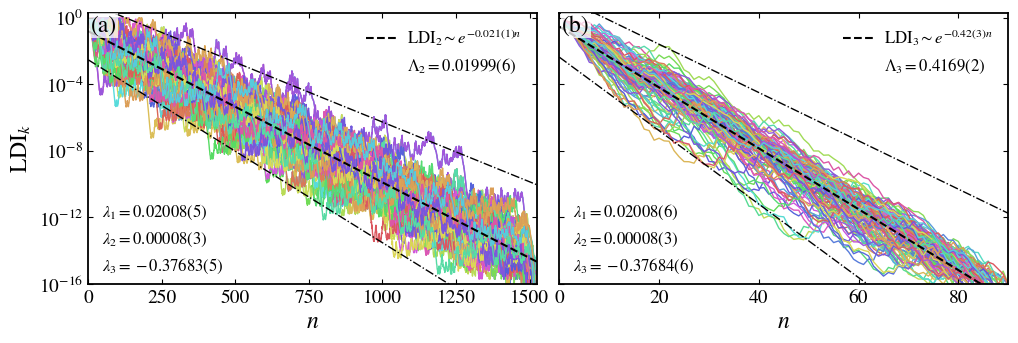

In [49]:
# -----------------------------
# Plot configuration
# -----------------------------
colors = sns.color_palette("hls", num_ic)
np.random.seed(1313)
np.random.shuffle(colors)
fontsize = 17
fontsize_legend = 12
ps = PlotStyler(fontsize=fontsize, legend_fontsize=fontsize_legend)
ps.apply_style()

fig, ax = plt.subplots(1, 2, figsize=(10, 3.25), sharey=True)

# Box style for subplot letters
bbox = {"facecolor": "w", "alpha": 0.75, "linewidth": 0.0, "pad": 1}

# -----------------------------
# Helper functions
# -----------------------------
def plot_exponential_fit(ax, x_new, a, b, std_a, std_b, nstd=3, label=None):
    """Plot exponential fit with uncertainty bands."""
    y_central = np.exp(b) * np.exp(a * x_new)
    y_upper = np.exp(b + nstd * std_b) * np.exp((a + nstd * std_a) * x_new)
    y_lower = np.exp(b - nstd * std_b) * np.exp((a - nstd * std_a) * x_new)

    ax.plot(x_new, y_central, color="black", lw=1.5, ls="--", label=label, zorder=1)
    ax.plot(x_new, y_upper, color="black", lw=1, ls="-.", zorder=2)
    ax.plot(x_new, y_lower, color="black", lw=1, ls="-.", zorder=2)

def add_lyapunov_text(ax, L_j):
    """Add mean and std of Lyapunov exponents."""
    for i in range(3):
        ax.text(
            0.03, 0.25 - fontsize_legend * i / 120,
            fr"$\lambda_{i + 1} = {format_mean_std(np.mean(L_j[i]), np.std(L_j[i], ddof=1))}$",
            transform=ax.transAxes, fontsize=fontsize_legend
        )

# -----------------------------
# Main plotting loop
# -----------------------------
for j in range(len(intervals)):
    # Add Lyapunov exponent annotations
    L = np.array(L)
    add_lyapunov_text(ax[j], L[:, j])

    # Plot LDI curves
    for i in range(num_ic):
        ax[j].plot(ldi[j][i][:, 0], ldi[j][i][:, 1], color=colors[i], zorder=0)

    # Exponential fit
    x_new = np.linspace(0, 10000, 1000)
    a, std_a = decays[j]
    b, std_b = Bs[j]
    label = fr"$\mathrm{{LDI}}_{j + 2} \sim e^{{{format_mean_std(a, std_a)}n}}$"
    plot_exponential_fit(ax[j], x_new, a, b, std_a, std_b, nstd=3, label=label)

    # Dummy plot for legend of Lambda
    ax[j].plot(
        0, 0, ".", color="black", markersize=0,
        label=fr"$\Lambda_{j + 2} = {format_mean_std(sum_diffs[j][0], sum_diffs[j][1])}$"
    )

    # Set y-scale and legend
    ax[j].set_yscale("log")
    ax[j].set_ylim(1e-16, np.sqrt(2))
    ax[j].legend(loc="upper right", frameon=False, ncol=1, columnspacing=-2., handletextpad=.5)

# -----------------------------
# Add subplot letters
# -----------------------------
xbox, ybox = 0.0059, 0.932
for i in range(2):
    ax[i].text(xbox, ybox, f"({ascii_lowercase[i]})", bbox=bbox, transform=ax[i].transAxes)

# -----------------------------
# Axis labels and limits
# -----------------------------
ax[0].set_ylabel(r"LDI$_k$")
ax[0].set_xlabel(r"$n$")
ax[1].set_xlabel(r"$n$")

ax[0].set_xlim(0, intervals[0][1])
ax[1].set_xlim(0, intervals[1][1])

ax[0].set_yscale("log")
ax[0].set_ylim(1e-16, 2)
ax[1].set_ylim(1e-16, 2)

ax[0].set_yticks([1e-16, 1e-12, 1e-8, 1e-4, 1e0])
ax[1].set_yticks([1e-16, 1e-12, 1e-8, 1e-4, 1e0])

# -----------------------------
# Adjust layout and save figure
# -----------------------------
plt.subplots_adjust(left=0.075, bottom=0.14, right=0.995, top=0.975, wspace=0.05, hspace=0.15)
plt.savefig("Figures/fig3.png", dpi=500)

# Fig. 4

In [11]:
N = LOGISTIC_MAP_NETWORK["network_size"]
ds = dds(mapping=logistic_map_network, jacobian=logistic_map_network_jacobian, system_dimension=N, number_of_parameters=4)

In [12]:
transient_time = LOGISTIC_MAP_NETWORK["transient_time"]
sample_size = LOGISTIC_MAP_NETWORK["sample_size"]
total_time = sample_size + transient_time
parameters = LOGISTIC_MAP_NETWORK["parameters"]
parameters.append(N)

np.random.seed(5)
u = np.random.uniform(0., 1, N) + 1e-4

In [16]:
sample_size

50000

In [13]:
trajectory = ds.trajectory(u, total_time, parameters=parameters, transient_time=transient_time)

In [14]:
lyapunovs = ds.lyapunov(u, total_time, parameters=parameters, transient_time=transient_time, return_history=True)

<Figure size 640x480 with 0 Axes>

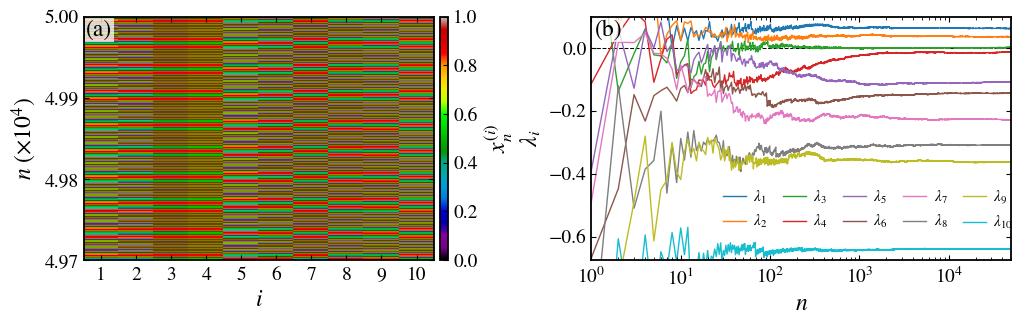

In [ ]:
ps = PlotStyler(fontsize=17, legend_fontsize=11)
ps.apply_style()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ps.set_tick_padding(ax[0], pad_x=5)
ps.set_tick_padding(ax[1], pad_x=5)
indexes = np.arange(1, trajectory.shape[1] + 1)
times = np.arange(1, trajectory.shape[0] + 1)
indexes, times = np.meshgrid(indexes, times)
hm = ax[0].pcolor(indexes, times / 1e4, trajectory, cmap="nipy_spectral", vmin=0, vmax=1)
plt.colorbar(hm, ax=ax[0], label=r"$x_n^{(i)}$", aspect=30, pad=0.015)

ax[0].set_xticks(np.arange(1, 11))
ax[0].set_ylim((sample_size - 300) / 1e4, sample_size / 1e4)
ax[0].set_xlabel(r"$i$")
ax[0].set_ylabel(r"$n$ ($\times10^4$)")

colors = sns.color_palette("tab10", N)
times = np.arange(1, sample_size + 1)# + transient_time
factor = np.ones(10)
factor[-1] = 0.5
for i in range(N):
    ax[1].plot(times, factor[i] * lyapunovs[:, i], color=colors[i], label=rf"$\lambda_{{{i + 1}}}$", zorder=1)
ax[1].axhline(0, color="black", linestyle="--", linewidth=0.75, zorder=0)
ax[1].legend(loc="upper left", ncol=5, frameon=False, handlelength=1.5, handletextpad=0.5, labelspacing=0.5, columnspacing=1, bbox_to_anchor=(0.28, 0.35))
ax[1].set_xlim(1, sample_size + 1)
ax[1].set_xscale("log")

ymin = lyapunovs[-1, :].min()
ymax = lyapunovs[-1, :].max()
ax[1].set_ylim(-0.675, 0.1)
ax[1].set_xlabel(r"$n$")
ax[1].set_ylabel(r"$\lambda_i$")

plt.subplots_adjust(left=0.07, bottom=0.16, right=0.9975, top=0.972, wspace=0.21)

bbox = {"facecolor": "w", "pad": 1, "alpha": 0.75, "linewidth": 0}
xbox = 0.0072
ybox = 0.922
for i in range(2):
    ax[1].text(xbox, ybox, f"({ascii_lowercase[i]})", transform=ax[i].transAxes, bbox=bbox)

plt.savefig("Figures/fig4.png", dpi=400)

# Fig. 5

In [19]:
# --------------------------
# Extract the data
# --------------------------
ldi = []
lyapunovs = []

ks = LOGISTIC_MAP_NETWORK["ks"]
intervals = LOGISTIC_MAP_NETWORK["intervals"]
num_ic = LOGISTIC_MAP_NETWORK["num_ic"]
path = LOGISTIC_MAP_NETWORK["path"]
N = LOGISTIC_MAP_NETWORK["network_size"]
for j in range(len(intervals)):
    aux_ldi = []
    aux_lyapunovs = []
    for i in range(num_ic):
        df = f"{path}/lmn_ldi_k={ks[j]}_ic={i}.dat"
        df = pd.read_csv(df, header=None, sep=r"\s+")
        l = np.zeros((len(df), 2))
        l[:, 0] = np.array(df[0])
        l[:, 1] = np.array(df[1])
        aux_ldi.append(l)
        df = f"{path}/lmn_lyapunov_k={ks[j]}_ic={i}.dat"
        df = pd.read_csv(df, header=None, sep=r"\s+")
        lypnv = np.array(df[1], dtype=np.float64)
        aux_lyapunovs.append(lypnv)
    ldi.append(aux_ldi)
    lyapunovs.append(aux_lyapunovs)

In [20]:
# --------------------------
# Perform the fitting
# --------------------------
decays = []
Bs = []
for j in range(len(intervals)):
    coeffs = np.zeros((num_ic, 2))
    for i in range(num_ic):
        y_fit = ldi[j][i][:, 1]
        x_fit = ldi[j][i][:, 0]
        x_fit = x_fit[y_fit > 0]
        y_fit = y_fit[y_fit > 0]
        coeffs[i] = np.polyfit(x_fit, np.log(y_fit), 1)

    decay = np.mean(coeffs[:, 0]), np.std(coeffs[:, 0], ddof=1)
    B = np.mean(coeffs[:, 1]), np.std(coeffs[:, 1], ddof=1)
    decays.append(decay)
    Bs.append(B)
decays

[(-0.048257799767770664, 0.004117181536431867),
 (-0.11223547901149172, 0.01434430165286668),
 (-0.2239165510146675, 0.019296422485125277),
 (-0.31074570752678954, 0.03072969168305425),
 (-0.6136920001735762, 0.04743326487934714),
 (-1.1528487363026245, 0.11346385956747866)]

In [21]:
L = [[] for _ in range(N)]
sum_diffs = []
for j in range(len(intervals)):
    k = ks[j]
    aux_l = [[] for _ in range(N)]
    for i in range(num_ic):
        for ii in range(N):
            aux_l[ii].append(lyapunovs[j][i][ii])
    for ii in range(N):
        L[ii].append(aux_l[ii])

    sum_l = 0
    err_sum_l = 0
    for l in range(1, k):
        aux_sum_l = propagate_error(lambda x, y: x - y, [np.mean(aux_l[0]), np.mean(aux_l[l])], [np.std(aux_l[0], ddof=1), np.std(aux_l[l], ddof=1)])
        sum_l += aux_sum_l[0]
        err_sum_l += aux_sum_l[1]
    sum_diffs.append([sum_l, err_sum_l])

In [22]:
colors = sns.color_palette("hls", num_ic)
np.random.seed(1313)
np.random.shuffle(colors)

<Figure size 640x480 with 0 Axes>

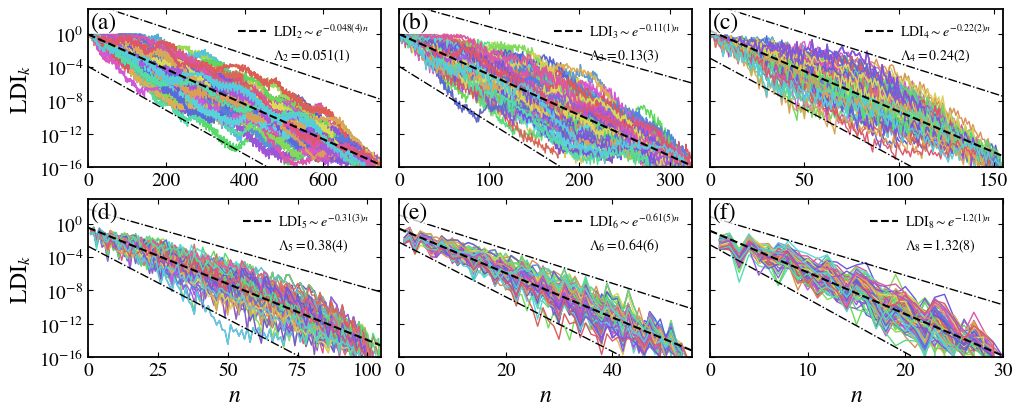

In [31]:
# -----------------------------
# Plot configuration
# -----------------------------
colors = sns.color_palette("hls", num_ic)
np.random.seed(1313)
np.random.shuffle(colors)
fontsize = 17
fontsize_legend = 10
ps = PlotStyler(fontsize=fontsize, legend_fontsize=fontsize_legend)
ps.apply_style()

fig, ax = plt.subplots(2, 3, figsize=(10, 4), sharey=True)

# Box style for subplot letters
bbox = {"facecolor": "w", "alpha": 0.75, "linewidth": 0.0, "pad": 1}

# -----------------------------
# Helper functions
# -----------------------------

def plot_exponential_fit(ax, x_new, a, b, std_a, std_b, nstd=3, label=None):
    """Plot exponential fit with uncertainty bands."""
    y_central = np.exp(b) * np.exp(a * x_new)
    y_upper = np.exp(b + nstd * std_b) * np.exp((a + nstd * std_a) * x_new)
    y_lower = np.exp(b - nstd * std_b) * np.exp((a - nstd * std_a) * x_new)

    ax.plot(x_new, y_central, color="black", lw=1.5, ls="--", label=label, zorder=1)
    ax.plot(x_new, y_upper, color="black", lw=1, ls="-.", zorder=2)
    ax.plot(x_new, y_lower, color="black", lw=1, ls="-.", zorder=2)

# -----------------------------
# Main plotting loop
# -----------------------------
for j in range(len(intervals)):
    ax_obj = ax.flat[j]

    # Plot LDI curves for each initial condition
    for i in range(num_ic):
        ax_obj.plot(ldi[j][i][:, 0], ldi[j][i][:, 1], color=colors[i], zorder=0)

    # Exponential fit with uncertainty bands
    x_new = np.linspace(0, 10000, 1000)
    a, std_a = decays[j]
    b, std_b = Bs[j]
    label = fr"$\mathrm{{LDI}}_{{{ks[j]}}} \sim e^{{{format_mean_std(a, std_a)}n}}$"
    plot_exponential_fit(ax_obj, x_new, a, b, std_a, std_b, nstd=3, label=label)

    # Dummy point for Lambda in legend
    ax_obj.plot(
        0, 0, ".", color="black", markersize=0,
        label=fr"$\Lambda_{{{ks[j]}}} = {format_mean_std(sum_diffs[j][0], sum_diffs[j][1])}$"
    )

    # Legend and y-axis scaling
    ax_obj.legend(loc="upper right", frameon=False, ncol=1, columnspacing=-2., handletextpad=.5)
    ax_obj.set_yscale("log")
    ax_obj.set_ylim(1e-16, np.sqrt(1e6))
    ax_obj.set_yticks([1e-16, 1e-12, 1e-8, 1e-4, 1e0])
    ax_obj.set_xlim(0, intervals[j][1])
    # ax_obj.set_ylabel(f"LDI$_{{{ks[j]}}}$")

# -----------------------------
# X-axis labels for bottom row
# -----------------------------
for col in range(3):
    ax[1, col].set_xlabel("$n$")
ax.flat[0].set_ylabel("LDI$_k$")
ax.flat[3].set_ylabel("LDI$_k$")
# -----------------------------
# Add subplot letters
# -----------------------------
xbox, ybox = 0.009, 0.883
for i in range(6):
    ax.flat[i].text(xbox, ybox, f"({ascii_lowercase[i]})", transform=ax.flat[i].transAxes, bbox=bbox)

# -----------------------------
# Layout adjustment and save
# -----------------------------
plt.subplots_adjust(left=0.075, bottom=0.115, right=0.99, top=0.985, hspace=0.2, wspace=0.06)
plt.savefig("Figures/fig5.png", dpi=400)

# Fig. 6

In [3]:
dof = FPU["dof"]
N = 2 * dof
ds = cds(equations_of_motion=fermi_pasta_ulam, jacobian=fermi_pasta_ulam_jacobian, system_dimension=N, number_of_parameters=1)
time_step = FPU["time_step"]
ds.integrator("rk4", time_step=time_step)

In [4]:
total_time = FPU["total_time"]
u = np.zeros(N)
X = FPU["X"]
u[2] = X
parameters = [FPU["beta"]]
E0 = fermi_pasta_ulam_energy(u, parameters)

In [5]:
E0

1.5

In [6]:
trajectory = ds.trajectory(u, total_time, parameters)

In [7]:
energy = fermi_pasta_ulam_energy(trajectory[:, 1:], parameters)

In [8]:
colors = sns.color_palette("hls", N)

In [9]:
lyapunovs = ds.lyapunov(u, total_time, parameters, return_history=True)

In [10]:
lyapunovs.shape

(2000002, 13)

In [11]:
lyapunovs[-1, 1:].sum()

-3.8826719617190975e-12

<Figure size 640x480 with 0 Axes>

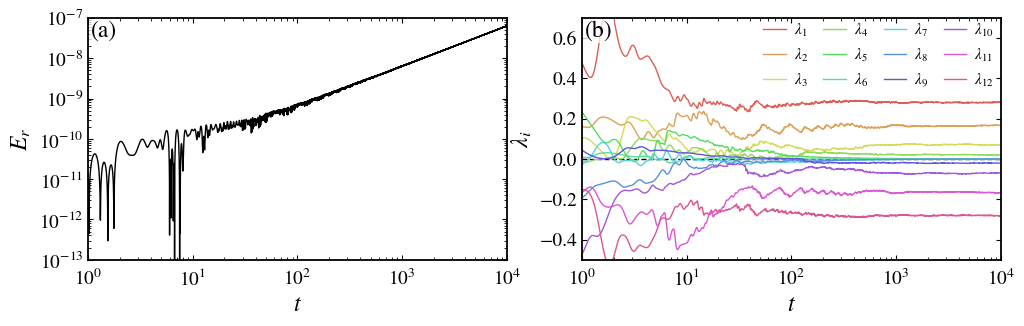

In [40]:
ps = PlotStyler(fontsize=17, legend_fontsize=11)
ps.apply_style()

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10, 3))
ps.set_tick_padding(ax[0], pad_x=6)
ps.set_tick_padding(ax[1], pad_x=6)

ax[0].plot(trajectory[:, 0], abs(energy - E0) / E0, "k")
ax[0].set_yscale("log")
ax[0].set_xlabel("$t$")
ax[0].set_ylabel("$E_r$")
ax[0].set_ylim(1e-13, 1e-7)

for i in range(lyapunovs.shape[1] - 1):
    ax[1].plot(lyapunovs[:, 0], lyapunovs[:, i + 1], c=colors[i], label=rf"$\lambda_{{{i + 1}}}$", zorder=2)
ax[1].axhline(0, c="k", ls="--", zorder=1)
ax[1].legend(loc="lower left", ncol=4, frameon=False, handlelength=1.5, handletextpad=0.5, labelspacing=0.5, columnspacing=1, bbox_to_anchor=(0.4, 0.65))
ax[1].set_xlabel("$t$")
ax[1].set_ylabel(r"$\lambda_i$")
# ax[1].set_ylim(-1, 1)
ax[1].set_ylim(-.5, .7)
# ax[1].set_yscale("log")
plt.xlim(1e0, total_time)
plt.xscale("log")

bbox = {"facecolor": "w", "linewidth": 0.0, "pad": 1, "alpha": 0.75}
xbox = 0.0065
ybox = 0.924
for i in range(2):
    ax[i].text(xbox, ybox, f"({ascii_lowercase[i]})", transform=ax[i].transAxes, bbox=bbox)

plt.subplots_adjust(left=0.075, bottom=0.16, right=0.9875, top=0.966, wspace=0.18)

plt.savefig("Figures/fig6.png", dpi=400)

# Fig. 7

In [3]:
ldi = []
lyapunovs = []
dof = FPU["dof"]
N = dof * 2
dx = FPU["dx"]
ks = FPU["ks"]
intervals = FPU["intervals"]
num_ic = FPU["num_ic"]
path = FPU["path"]
time_step = FPU["time_step"]
for j in range(len(intervals)):
    aux_ldi = []
    aux_lyapunovs = []
    for i in range(num_ic):
        df = f"{path}/fpu_ldi_k={ks[j]}_ic={i}.dat"
        df = pd.read_csv(df, header=None, sep=r"\s+")
        l = np.zeros((len(df), 2))
        l[:, 0] = np.array(df[0])
        l[:, 1] = np.array(df[1])
        aux_ldi.append(l)
        df = f"{path}/fpu_lyapunov_k={ks[j]}_ic={i}.dat"
        df = pd.read_csv(df, header=None, sep=r"\s+")
        lypnv = np.array(df[1], dtype=np.float64)
        aux_lyapunovs.append(lypnv)
    ldi.append(aux_ldi)
    lyapunovs.append(aux_lyapunovs)

In [4]:
decays = []
Bs = []
for j in range(len(intervals)):
    coeffs = np.zeros((num_ic, 2))
    for i in range(num_ic):
        x_fit = ldi[j][i][:, 0]
        y_fit = ldi[j][i][:, 1]
        x_fit = x_fit[y_fit > 0]
        y_fit = y_fit[y_fit > 0]
        coeffs[i] = np.polyfit(x_fit, np.log(y_fit), 1)

    decay = np.mean(coeffs[:, 0]), np.std(coeffs[:, 0], ddof=1)
    B = np.mean(coeffs[:, 1]), np.std(coeffs[:, 1], ddof=1)
    decays.append(decay)
    Bs.append(B)
decays, Bs

([(-0.08834779205606821, 0.008556120221586765),
  (-0.2548380503972495, 0.013236365886120063),
  (-0.41109821578547723, 0.03579942947184252),
  (-0.6521030957924845, 0.017500758803929598),
  (-0.7238931423944976, 0.042366382399587024),
  (-1.3206073005096315, 0.026155427387373087)],
 [(1.9193084042807937, 3.1318232746758135),
  (0.8972515264150798, 0.06946482740508225),
  (-0.0440337589517761, 0.32063201277240544),
  (-1.5145159974888995, 0.07018576580298962),
  (-1.0399817257421078, 0.1478540548706983),
  (-1.2648241199594776, 0.06658304497111325)])

In [5]:
L = [[] for _ in range(N)]
sum_diffs = []
for j in range(len(intervals)):
    k = ks[j]
    aux_l = [[] for _ in range(N)]
    for i in range(num_ic):
        for ii in range(N):
            aux_l[ii].append(lyapunovs[j][i][ii])
    for ii in range(N):
        L[ii].append(aux_l[ii])

    sum_l = 0
    err_sum_l = 0
    for l in range(1, k):
        aux_sum_l = propagate_error(lambda x, y: x - y, [np.mean(aux_l[0]), np.mean(aux_l[l])], [np.std(aux_l[0], ddof=1), np.std(aux_l[l], ddof=1)])
        sum_l += aux_sum_l[0]
        err_sum_l += aux_sum_l[1]
    sum_diffs.append([sum_l, err_sum_l])

<Figure size 640x480 with 0 Axes>

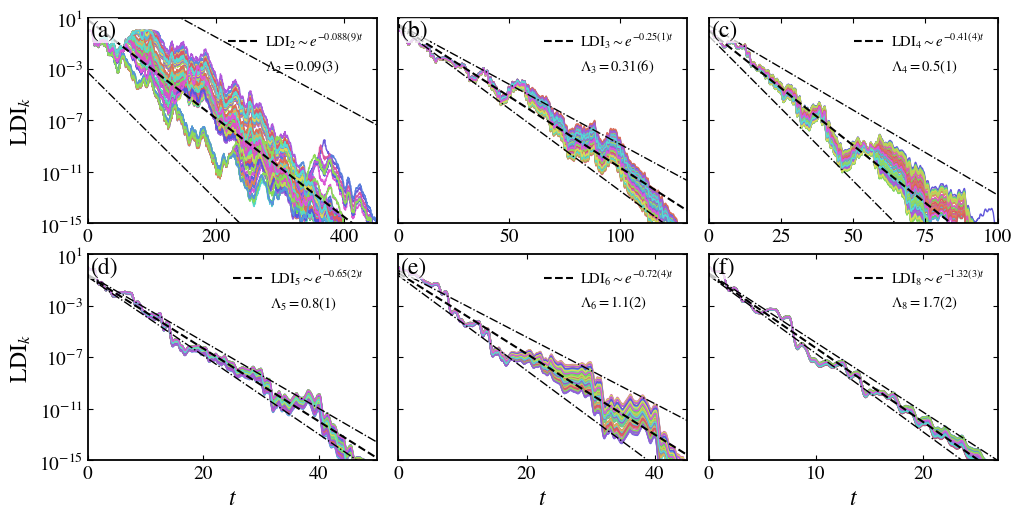

In [18]:
colors = sns.color_palette("hls", num_ic)
np.random.seed(13)
np.random.shuffle(colors)
# -----------------------------
# Plot configuration
# -----------------------------
fontsize = 17
fontsize_legend = 10.5
ps = PlotStyler(fontsize=fontsize, legend_fontsize=fontsize_legend)
ps.apply_style()

fig, ax = plt.subplots(2, 3, figsize=(10, 5), sharey=True)

# -----------------------------
# Helper functions
# -----------------------------
def plot_exponential_fit(ax, x_new, a, b, std_a, std_b, nstd=3, label=None):
    """Plot exponential fit with uncertainty bands."""
    y_central = np.exp(b) * np.exp(a * x_new)
    y_upper = np.exp(b + nstd * std_b) * np.exp((a + nstd * std_a) * x_new)
    y_lower = np.exp(b - nstd * std_b) * np.exp((a - nstd * std_a) * x_new)

    ax.plot(x_new, y_central, color="black", lw=1.5, ls="--", label=label, zorder=1)
    ax.plot(x_new, y_upper, color="black", lw=1, ls="-.", zorder=2)
    ax.plot(x_new, y_lower, color="black", lw=1, ls="-.", zorder=2)

def add_lyapunov_text(ax, L_j):
    """Add mean and std of Lyapunov exponents."""
    for i in range(len(N)):
        ax.text(
            0.03, 0.32 - fontsize_legend * i / 120,
            fr"$\lambda_{i + 1} = {format_mean_std(np.mean(L_j[i]), np.std(L_j[i], ddof=1))}$",
            transform=ax.transAxes, fontsize=fontsize_legend
        )

# -----------------------------
# Main plotting loop
# -----------------------------

for j in range(len(intervals)):
    # Add Lyapunov exponent annotations
    L = np.array(L)
    # add_lyapunov_text(ax.flat[j], L[:, j])

    # Plot LDI curves
    for i in range(num_ic):
        ax.flat[j].plot(ldi[j][i][:, 0], ldi[j][i][:, 1], color=colors[i], zorder=0)

    # Exponential fit
    x_new = np.linspace(0, 5000, 10000)
    a, std_a = decays[j]
    b, std_b = Bs[j]
    label = fr"$\mathrm{{LDI}}_{{{ks[j]}}} \sim e^{{{format_mean_std(a, std_a)}t}}$"
    plot_exponential_fit(ax.flat[j], x_new, a, b, std_a, std_b, nstd=3, label=label)

    # Dummy plot for legend of Lambda
    ax.flat[j].plot(
        0, 0, ".", color="black", markersize=0,
        label=fr"$\Lambda_{{{ks[j]}}} = {format_mean_std(sum_diffs[j][0], sum_diffs[j][1])}$"
    )

    # Set y-scale and legend
    ax.flat[j].set_yscale("log")
    ax.flat[j].set_ylim(1e-15, 1e1)
    # ax.flat[j].set_ylabel(rf"$\mathrm{{LDI}}_{{{ks[j]}}}$")
    ax.flat[j].legend(loc="upper right", frameon=False, ncol=1, columnspacing=-2., handletextpad=.5)
    ax.flat[j].set_xlim(0, intervals[j][1])

# -----------------------------
# Add subplot letters
# -----------------------------
xbox, ybox = 0.0102, 0.9093
# Box style for subplot letters
bbox = {"facecolor": "w", "alpha": 0.75, "linewidth": 0.0, "pad": 1}
for i in range(len(ax.flat)):
    ax.flat[i].text(xbox, ybox, f"({ascii_lowercase[i]})", bbox=bbox, transform=ax.flat[i].transAxes)

# -----------------------------
# Axis labels and limits
# -----------------------------
ax.flat[0].set_ylabel("LDI$_k$")
ax.flat[3].set_ylabel("LDI$_k$")
ax.flat[3].set_xlabel(r"$t$")
ax.flat[4].set_xlabel(r"$t$")
ax.flat[5].set_xlabel(r"$t$")

# ax.flat[0].set_xlim(0, 450)
ax.flat[1].set_xlim(0, 130)
# ax.flat[2].set_xlim(0, 110)
# ax.flat[3].set_xlim(0, 100)
# ax.flat[4].set_xlim(0, 50)
# ax.flat[5].set_xlim(0, 50)

# -----------------------------
# Adjust layout and save figure
# -----------------------------
plt.subplots_adjust(left=0.075, bottom=0.09, right=0.985, top=0.975, wspace=0.075, hspace=0.15)
plt.savefig("Figures/fig7.png", dpi=500)

# Fig. 8

In [ ]:
x_ini, x_end = 0.2, 0.26
y_ini, y_end = 0.2, 0.3
num_ic = 20000
x = np.random.uniform(x_ini, x_end, num_ic)
y = np.random.uniform(y_ini, y_end, num_ic)
u = np.stack([x, y]).T
total_time = 100
ds_CM = dds(mapping=cat_map, jacobian=cat_map_jacobian, system_dimension=2, number_of_parameters=0)
ds_BM = dds(mapping=baker_map, jacobian=baker_map_jacobian, system_dimension=2, number_of_parameters=1)

In [ ]:
colors = sns.color_palette("hls", num_ic)
np.random.seed(1313)
np.random.shuffle(colors)

In [ ]:
ts_CM = ds_CM.trajectory(u, total_time).reshape(num_ic, total_time, 2)

In [ ]:
parameters = 0.3
transient_time = 1
ts_BM = ds_BM.trajectory(u, total_time, parameters=parameters, transient_time=transient_time).reshape(num_ic, total_time - transient_time, 2)

<Figure size 640x480 with 0 Axes>

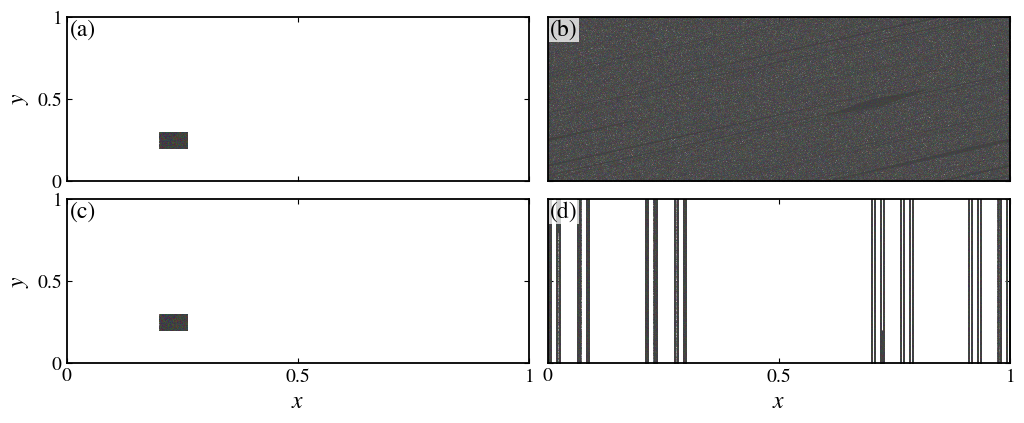

In [ ]:
fontsize = 17
ps = PlotStyler(fontsize=fontsize, markersize=0.2, markeredgewidth=0)
ps.apply_style()
fig, ax = plt.subplots(2, 2, figsize=(10, 4), sharex=True, sharey=True)

ms = 0.2
for i in range(num_ic):
    ax[0, 0].plot(x[i], y[i], 'o', markersize=ms * 2, markeredgewidth=0, c=colors[i]);
ax[0, 0].set_xlim(0, 1)
ax[0, 0].set_ylim(0, 1)
for i in range(num_ic):
    ax[0, 1].plot(ts_CM[i, :, 0], ts_CM[i, :, 1], 'o', c=colors[i]);

for i in range(num_ic):
    ax[1, 0].plot(x[i], y[i], 'o', markersize=ms * 2, c=colors[i]);
ax[1, 0].set_xlim(0, 1)
ax[1, 0].set_ylim(0, 1)
for i in range(num_ic):
    ax[1, 1].plot(ts_BM[i, :, 0], ts_BM[i, :, 1], 'o', c=colors[i]);

ax[0, 0].set_xticks([0, 0.5, 1], [r"$0$", r"$0.5$", r"$1$"])
ax[0, 0].set_yticks([0, 0.5, 1], [r"$0$", r"$0.5$", r"$1$"])
ax[0, 0].set_ylabel(r"$y$")
ax[1, 0].set_ylabel(r"$y$")
ax[1, 0].set_xlabel(r"$x$")
ax[1, 1].set_xlabel(r"$x$")

xbox = 0.0055
ybox = 0.8845
bbox = {"facecolor": "w", "alpha": 0.75, "linewidth": 0.0, "pad": 1}

for i in range(4):
    ax.flat[i].text(xbox, ybox, f"({ascii_lowercase[i]})", bbox=bbox, transform=ax.flat[i].transAxes)

plt.subplots_adjust(left=0.052, bottom=0.114, right=0.995, top=0.98, wspace=0.04, hspace=0.11)

plt.savefig("Figures/fig8.png", dpi=300)

# Fig. 9

In [ ]:
sali = []
path = CATMAP["path"]
num_ic = CATMAP["num_ic"]
for i in range(num_ic):
    df = pd.read_csv(f"{path}/catmap_sali_ic={i}.dat", header=None, sep=r"\s+")
    s = np.zeros((len(df), 2))
    s[:, 0] = np.array(df[0])
    s[:, 1] = np.array(df[1])
    sali.append(s)

In [ ]:
coeffs = np.zeros((num_ic, 2))
for i in range(num_ic):
    y_fit = sali[i][:, 1]
    x_fit = sali[i][:, 0]
    x_fit = x_fit[y_fit > 0]
    y_fit = y_fit[y_fit > 0]
    coeffs[i] = np.polyfit(x_fit, np.log(y_fit), 1)

In [ ]:
B = np.mean(coeffs[:, 1]), np.std(coeffs[:, 1])
decay = np.mean(coeffs[:, 0]), np.std(coeffs[:, 0])
decay, B

((np.float64(-1.9180325681615507), np.float64(0.011320540223224925)),
 (np.float64(1.3064248857779348), np.float64(0.6843132424518734)))

## Baker map

In [ ]:
sali_bm = []
path = BAKERMAP["path"]
num_ic = BAKERMAP["num_ic"]
for i in range(num_ic):
    df = pd.read_csv(f"{path}/bakermap_sali_ic={i}.dat", header=None, sep=r"\s+")
    s = np.zeros((len(df), 2))
    s[:, 0] = np.array(df[0])
    s[:, 1] = np.array(df[1])
    sali_bm.append(s)

In [ ]:
coeffs_bm = np.zeros((num_ic, 2))
for i in range(num_ic):
    y_fit = sali_bm[i][:, 1]
    x_fit = sali_bm[i][:, 0]
    x_fit = x_fit[y_fit > 0]
    y_fit = y_fit[y_fit > 0]
    coeffs_bm[i] = np.polyfit(x_fit, np.log(y_fit), 1)

In [ ]:
B_bm = np.mean(coeffs_bm[:, 1]), np.std(coeffs_bm[:, 1])
decay_bm = np.mean(coeffs_bm[:, 0]), np.std(coeffs_bm[:, 0])
decay_bm, B_bm

((np.float64(-1.8918665663543774), np.float64(0.005987828653572975)),
 (np.float64(1.1625295279007803), np.float64(0.7258501469308062)))

## Plot

In [ ]:
colors = sns.color_palette("hls", num_ic)
np.random.seed(1313)
np.random.shuffle(colors)

<Figure size 640x480 with 0 Axes>

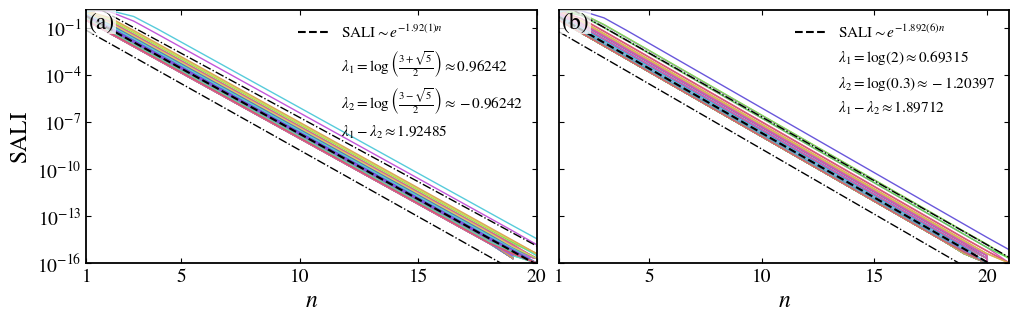

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from string import ascii_lowercase

# -----------------------------
# Plot configuration
# -----------------------------
fontsize = 17
fontsize_legend = 11
ps = PlotStyler(fontsize=fontsize, legend_fontsize=fontsize_legend)
ps.apply_style()

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 3))
lw = 1

# Box style for subplot letters
bbox = {"facecolor": "white", "alpha": 0.75, "linewidth": 0.0, "pad": 1}

# -----------------------------
# Helper functions
# -----------------------------
def plot_sali_curves(ax_obj, sali_list, colors, lw=1):
    """Plot SALI curves for all initial conditions."""
    max_time = -np.inf
    for i, s in enumerate(sali_list):
        times = np.arange(1, len(s) + 1)
        max_time = max(max_time, times[-1])
        ax_obj.plot(times, s, color=colors[i], lw=lw)
    return max_time

def plot_exponential_fit(ax_obj, x_new, a, b, std_a, std_b, nstd=3, label=None):
    """Plot exponential decay/growth fit with uncertainty bands."""
    y_central = np.exp(b) * np.exp(a * x_new)
    y_upper = np.exp(b + nstd * std_b) * np.exp((a + nstd * std_a) * x_new)
    y_lower = np.exp(b - nstd * std_b) * np.exp((a - nstd * std_a) * x_new)

    ax_obj.plot(x_new, y_central, color="black", lw=1.5, ls="--", label=label)
    ax_obj.plot(x_new, y_upper, color="black", lw=1, ls="-.")
    ax_obj.plot(x_new, y_lower, color="black", lw=1, ls="-.")

def add_fixed_lyapunov_labels(ax_obj, labels):
    """Add fixed Lyapunov exponent labels as invisible points for legend."""
    for label in labels:
        ax_obj.plot(0, 0, color="black", lw=0, label=label)

# -----------------------------
# Plot SALI curves and fits
# -----------------------------
# Cat map
max_time = plot_sali_curves(ax[0], sali, colors, lw=lw)
x_new = np.linspace(1, max_time, 100)
plot_exponential_fit(ax[0], x_new, decay[0], B[0], decay[1], B[1], nstd=3,
                     label=fr"$\mathrm{{SALI}} \sim e^{{{format_mean_std(decay[0], decay[1])}n}}$")
add_fixed_lyapunov_labels(ax[0], [
    r"$\lambda_1 = \log\left(\frac{3 + \sqrt{5}}{2}\right) \approx 0.96242$",
    r"$\lambda_2 = \log\left(\frac{3 - \sqrt{5}}{2}\right) \approx -0.96242$",
    r"$\lambda_1 - \lambda_2 \approx 1.92485$"
])
ax[0].set_ylabel("SALI")
ax[0].set_xlabel("$n$")
ax[0].set_xlim(1, 20)
ax[0].set_yscale("log")
ax[0].set_ylim(1e-16, np.sqrt(2))
ax[0].set_xticks([1, 5, 10, 15, 20])
ax[0].legend(loc="upper right", frameon=False)

# Baker map
max_time_bm = plot_sali_curves(ax[1], sali_bm, colors, lw=lw)
x_new = np.linspace(1, max_time_bm, 100)
plot_exponential_fit(ax[1], x_new, decay_bm[0], B_bm[0], decay_bm[1], B_bm[1], nstd=3,
                     label=fr"$\mathrm{{SALI}} \sim e^{{{format_mean_std(decay_bm[0], decay_bm[1])}n}}$")
add_fixed_lyapunov_labels(ax[1], [
    r"$\lambda_1 = \log(2) \approx 0.69315$",
    r"$\lambda_2 = \log(0.3) \approx -1.20397$",
    r"$\lambda_1 - \lambda_2 \approx 1.89712$"
])
ax[1].set_xlabel("$n$")
ax[1].set_xlim(1, 21)
ax[1].set_xticks([1, 5, 10, 15, 20])
ax[1].legend(loc="upper right", frameon=False)

# -----------------------------
# Add subplot letters
# -----------------------------
for i in range(2):
    ax[i].text(0.0056, 0.927, f"({ascii_lowercase[i]})", transform=ax[i].transAxes, bbox=bbox)

# -----------------------------
# Adjust layout and save figure
# -----------------------------
plt.subplots_adjust(left=0.075, bottom=0.15, right=0.998, top=0.995, wspace=0.05, hspace=0.08)
plt.savefig("Figures/fig9.png", dpi=600)